### Imports

In [1]:
import os

import numpy as np
import pandas as pd
from tqdm import trange
from pathlib import Path

import torch
import pickle
import string
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

from cdt.metrics import SHD

from simulation.simulation_tools import get_optimal_sim_XY, get_optimal_sim_XY_dual
from utils import custom_binary_metrics, _from_full_to_cp

rng = np.random.default_rng()

COL_NAMES = list(string.ascii_uppercase) + ["".join(a) for a in list(itertools.permutations(list(string.ascii_uppercase), r=2))]

Detecting 1 CUDA device(s).


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


### Experiment - Impact of the Sparsity Penalty on Increasing Edges

In [ ]:
# data_path
ie_custom_path = list(Path(".").resolve().parents)[1] / "data" / "cp_style" / "increasing_edges_cp_1"

# placeholders
errors = []
scm_list = {}
shd_list = {}
scores_list = {}
det_auc_list = {}
struct_auc_list = {}

errors_w = []
scm_list_w = {}
shd_list_w = {}
scores_list_w = {}
det_auc_list_w = {}
struct_auc_list_w = {}


# run loop
for fn in os.listdir(ie_custom_path / "data"):
        print(f"\n\n------------------------------------- {fn} -------------------------------------")

        # read the time-series
        X_data = pd.read_csv(ie_custom_path / "data" / fn)
        X_data.rename(columns=dict(zip(X_data.columns, COL_NAMES[:X_data.shape[1]])), inplace=True)

        # read the ground truth
        gn = fn.split("_ts")[0] + "_struct.pt"
        Y_data = torch.load(ie_custom_path / "structure" / gn)
        # print(f"- edges : {Y_data.sum().int()}")

        # optimal simulation
        res, res_s = get_optimal_sim_XY_dual(
                true_data = X_data, 
                CONFIGS = None, 
                done_eval = False,
                optimal_det_config = None,
                optimal_det_func = None, 
                sparsity_penalty=True,
                verbose = True
        )

        # compare
        if isinstance(res["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res["optimal_scm"])
        else:
                pred_cp = res["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list[fn] =  pred_cp
        scores_list[fn] =  res["scores"]
        det_auc_list[fn] =  res["auc"]
        struct_auc_list[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list[fn] = shd_d

        # ___________________________________________________________________________________________


        # compare
        if isinstance(res_s["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res_s["optimal_scm"])
        else:
                pred_cp = res_s["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list_w[fn] =  pred_cp
        scores_list_w[fn] =  res_s["scores"]
        det_auc_list_w[fn] =  res_s["auc"]
        struct_auc_list_w[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list_w[fn] = shd_d

### Store Results

In [ ]:
# merge
res_both = {
    "res" : struct_auc_list,
    "res_w" : struct_auc_list_w, 
}

# # store results
# pickle.dump(res_both, open(list(Path(".").resolve().parents)[1] / "data" / "results" / "sparsity_penalty" / "res_cp_vs_2.p", "wb"))

### Plot

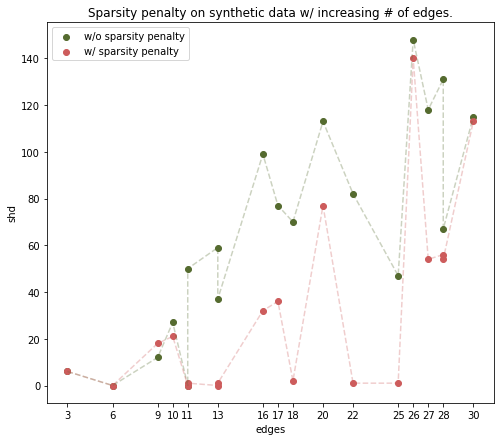

In [2]:
# load data
res_both = pickle.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "sparsity_penalty" / "res_cp_vs_2.p", "rb"))

# sort results according to ground truth edge density
sorted_true, sorted_shd = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res'].values())], 
    [v["shd"] for v in list(res_both['res'].values())])), key=lambda x: x[0])[:])) 

sorted_true_w, sorted_shd_w = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res_w'].values())], 
    [v["shd"] for v in list(res_both['res_w'].values())])), key=lambda x: x[0])[:])) 

# plot
f, ax = plt.subplots(figsize=(8, 7))
ax.scatter(x=sorted_true, y=sorted_shd, label="w/o sparsity penalty", color="darkolivegreen")
ax.plot(sorted_true, sorted_shd, "--", color="darkolivegreen", alpha=0.3)
ax.scatter(x=sorted_true_w, y=sorted_shd_w, label="w/ sparsity penalty", color='indianred')
ax.plot(sorted_true_w, sorted_shd_w, "--", color='indianred', alpha=0.3)
ax.set_xticks(list(set([int(x) for x in sorted_true])))
ax.set_xticklabels(list(set([int(x) for x in sorted_true])))
ax.set_xlabel("edges")
ax.set_ylabel("shd")
ax.set_title("Sparsity penalty on synthetic data w/ increasing # of edges.")
ax.legend()
plt.show()